# Naive bayes classifier

Create a Naive Bayes classifier for each handwritten digit that support discrete and continuous features

### inputs

- Train and Test images data from [MNIST](http://yann.lecun.com/exdb/mnist/)
- Train and Test labels data 

### outputs

- posterior (in log scale to avoid underflow) of the ten categories (0-9) for each row in test images
- error rate 

In [448]:
import matplotlib.pyplot as plt
from functools import reduce
from IPython.display import Latex
import numpy as np
from math import log, sqrt, exp, pi, factorial, erf
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure.figsize = (8,8) 

In [54]:
def showBytesImage(byte, row = 28, col = 28):
    im = [[byte[i*28 + j] for j in range(col)] for i in range(row)]
    
    plt.imshow(im, cmap='gray')
    

class idx_file():
    def __init__(self, file):
        self.filename = file
        self.datas = []
        
        with open(self.filename, mode='rb') as f:
            magic_number = f.read(4)
            
            self.n_dim = magic_number[-1]
            
            self.n_dims = [int.from_bytes(f.read(4), byteorder='big') for _ in range(self.n_dim)]
    
            for idx in range(self.n_dims[0]):
                item = f.read(reduce(lambda x,y: x*y, (self.n_dims[1:] + [1])))
        
                self.datas.append(item)
        

In [109]:
%%time

train_images = idx_file('train-images.idx3-ubyte')

train_labels = idx_file('train-labels.idx1-ubyte')

test_images = idx_file('t10k-images.idx3-ubyte')

test_labels = idx_file('t10k-labels.idx1-ubyte')

CPU times: user 195 ms, sys: 28 ms, total: 223 ms
Wall time: 223 ms


In [380]:
(len(train_images.datas), len(test_images.datas))

(60000, 10000)

labels [10] : 3


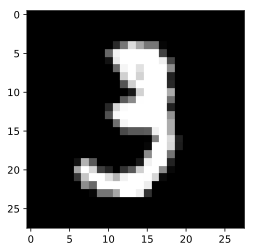

In [388]:
data_idx = 10
showBytesImage(train_images.datas[data_idx])
print("labels [{}] : {}".format(data_idx, train_labels.datas[data_idx][0]))

### handle feature

- discrete

map 0 ~ 255 into 0 ~ 31 bins

note : handle empty bins

- continuous

get mean and variance

use gaussian distribution to perform

and use integral to get probability

### discrete

- Pixel_Count
    - class : 0~9
    - pixels : 0~783
    - bins : 0~31
    
- Class_Count
    - class : 0~9

In [390]:
%%time
# Pixel_Count[class][pixels][bins]

Bins_default = 10**-6
Pixel_Count = [[[Bins_default for _ in range(32)] for _ in range(28*28)] for _ in range(10)]

Class_Count = [0 for _ in range(10)]

for idx, bs in enumerate(train_images.datas):
    Class_Count[train_labels.datas[idx][0]] += 1
    for i in range(len(bs)):
        Pixel_Count[train_labels.datas[idx][0]][i][bs[i]>>3] += 1

CPU times: user 21.3 s, sys: 11.6 ms, total: 21.3 s
Wall time: 21.3 s


<function matplotlib.pyplot.plot(*args, **kwargs)>

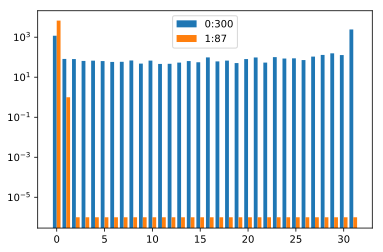

In [408]:
plt.bar([x-0.2 for x in range(32)], Pixel_Count[0][300], label="0:300", log=True, width=0.4)
plt.bar([x+0.2 for x in range(32)], Pixel_Count[1][87], label="1:87", log=True, width=0.4)
plt.legend()
plt.plot

In [410]:
%%time

error_D = 0
Posterior_D = [[0 for _ in range(10)] for _ in range(len(test_images.datas))]
for idx, bs in enumerate(test_images.datas):
    for num in range(10):
        for i in range(len(bs)):
            Posterior_D[idx][num] += log(Pixel_Count[num][i][bs[i]>>3])
        Posterior_D[idx][num] -= (len(bs)-1)*log(Class_Count[num])
        #Posterior[idx][num] += log(Class_P[num])
    
    predict = np.argmax(Posterior_D[idx])
    answer = test_labels.datas[idx][0]
    
    if predict != answer:
        error_D += 1

CPU times: user 48.6 s, sys: 10.9 ms, total: 48.6 s
Wall time: 48.6 s


In [446]:
def showPosterior_D(idx):
    print("index[{}] label : {}, predict : {}".format(idx, test_labels.datas[idx][0], np.argmax(Posterior_D[idx])))
    print("index[{}] Posterior array : {}".format(idx, Posterior_D[idx]))
    plt.bar(range(10), Posterior_D[idx],label="idx={}".format(idx))
    plt.legend()

index[87] label : 3, predict : 3
index[87] Posterior array : [-786.7561112401281, -1256.3236615533442, -778.6245269050132, -645.5845958139043, -721.9587667077876, -669.6875992418154, -771.2265159092894, -777.4349113136195, -739.5660244603814, -848.9492005385937]


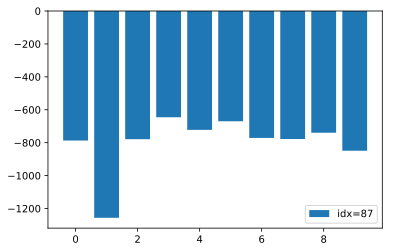

In [447]:
showPosterior_D(87)

In [460]:
"error rate of discrete : {}".format(error_D/len(test_images.datas))

'error rate of discrete : 0.1492'

### continuous

- Pixel_datas
    - class
    - pixels

- Pixel_G
    - class
    - pixels
    - mean, variance, Gaussian distribution, Cumulative Distribution Function
    
- Class_Count
    - class : 0~9

In [437]:
%%time
# class, pixels

Pixel_datas = [[[] for _ in range(28*28)] for _ in range(10)]

for idx, bs in enumerate(train_images.datas):
    for i in range(len(bs)):
        Pixel_datas[train_labels.datas[idx][0]][i].append(bs[i])

CPU times: user 19.3 s, sys: 11.7 ms, total: 19.3 s
Wall time: 19.3 s


In [464]:
def Gaussian(u, v):
    return lambda x : (exp(-1*(((x - u)**2) / (2*v) ) ) / sqrt(2*pi*v))

def CDF(u, v):
    return lambda x : 0.5*(1 + erf((x - u)/(sqrt(2*v))))

def PDF(x, width, cdf):
    a = cdf(x - width/2)
    b = cdf(x + width/2)
    return b-a

def Normalize(a):
    n = sum(a)
    if n < 0:
        n *= -1
    return [x/n for x in a]

In [480]:
%%time

Pixel_G = [[[0, 0] for _ in range(28*28)] for _ in range(10)]
#Variance_zero = 10**-6
Variance_zero = 10**3

for i in range(10):
    for j in range(28*28):
        n = len(Pixel_datas[i][j])
        u = sum(Pixel_datas[i][j]) / n
        v = sum([(x - u)**2 for x in Pixel_datas[i][j]]) / n
        Pixel_G[i][j][0] = u
        if v <= Variance_zero:
            v = Variance_zero
        Pixel_G[i][j][1] = v
        Pixel_G[i][j].append(Gaussian(u, v))
        Pixel_G[i][j].append(CDF(u, v))

CPU times: user 8.06 s, sys: 15.5 ms, total: 8.08 s
Wall time: 8.08 s


<function matplotlib.pyplot.plot(*args, **kwargs)>

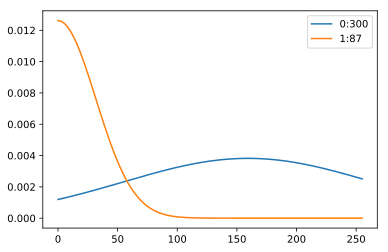

In [500]:
plt.plot(range(256), [Pixel_G[0][300][2](x) for x in range(256)], label="0:300")
plt.plot(range(256), [Pixel_G[1][87][2](x) for x in range(256)], label="1:87")
plt.legend()
plt.plot

<function matplotlib.pyplot.plot(*args, **kwargs)>

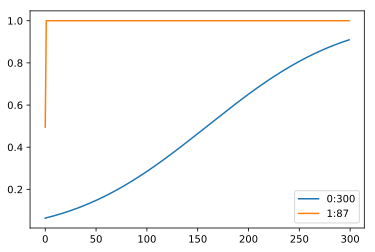

In [467]:
plt.plot(range(300), [Pixel_G[0][300][3](x) for x in range(300)], label="0:300")
plt.plot(range(300), [Pixel_G[1][87][3](x) for x in range(300)], label="1:87")
plt.legend()
plt.plot

<function matplotlib.pyplot.plot(*args, **kwargs)>

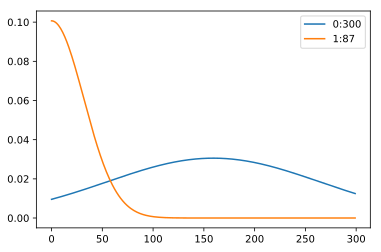

In [505]:
width_G = 256/32

plt.plot(range(300), [PDF(x, width_G, Pixel_G[0][300][3]) for x in range(300)], label="0:300")
plt.plot(range(300), [PDF(x, width_G, Pixel_G[1][87][3]) for x in range(300)], label="1:87")
plt.legend()
plt.plot

In [503]:
%%time

error_G = 0
width_G = 1
log_zero = 10**-10
Posterior_G = [[0 for _ in range(10)] for _ in range(len(test_images.datas))]
for idx, bs in enumerate(test_images.datas):
    for num in range(10):
        for i in range(len(bs)):
            # using PDF
            p = PDF(bs[i], width_G, Pixel_G[num][i][3])
            # using Gaussian distribution
            # p = Pixel_G[num][i][2](bs[i])
            if p <= log_zero:
                Posterior_G[idx][num] += log(log_zero)
                continue;
            Posterior_G[idx][num] += log(p)
        Posterior_G[idx][num] += log(Class_Count[num])
    
    predict = np.argmax(Posterior_G[idx])
    answer = test_labels.datas[idx][0]
    
    if predict != answer:
        error_G += 1

CPU times: user 3min 18s, sys: 40.5 ms, total: 3min 18s
Wall time: 3min 18s


In [504]:
"error rate of continuous : {}".format(error_G/len(test_images.datas))

'error rate of continuous : 0.17'

In [474]:
def showPosterior_G(idx):
    print("index[{}] label : {}, predict : {}".format(idx, test_labels.datas[idx][0], np.argmax(Posterior_G[idx])))
    print("index[{}] Posterior array : {}".format(idx, Posterior_G[idx]))
    plt.bar(range(10), Posterior_G[idx],label="idx={}".format(idx))
    plt.legend()

index[87] label : 3, predict : 3
index[87] Posterior array : [-1869.7513977046206, -2144.8232350694993, -2000.1064161757333, -1637.8896993549176, -1783.2809078662738, -1796.939082845353, -1838.5093126138293, -1867.7252527684168, -1825.9630887401981, -1792.0670333230537]


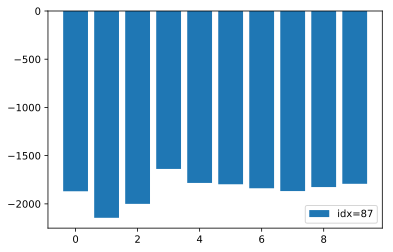

In [475]:
showPosterior_G(87)

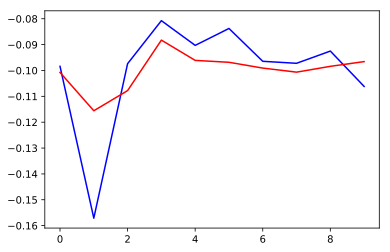

In [478]:
plt.plot(range(10), Normalize(Posterior_D[87]), 'b')
plt.plot(range(10), Normalize(Posterior_G[87]), 'r')

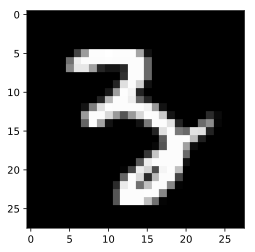

In [355]:
showBytesImage(test_images.datas[87])

# online learning

Use online learning to learn the beta distribution of the parameter p of the coin tossing trails in batch. 

### inputs

- some binary outcome

e.g.

`01010101100`

`0110101`

...

- parameter `a` , `b` for the initial beta distribution prior

### outputs

- Binomial MLE
- Prior parameter
- Posterior parameter

In [330]:
def Beta_distribution(a, b):
    c = 1/Beta(a,b)
    return lambda p : (p**(a-1)) * ((1-p)**(b-1)) * c

def Beta(a,b):
    return (Gamma(a) * Gamma(b)) / Gamma(a + b)

def Gamma(x):
    return factorial(x - 1)

def Likelihood(p, N, m):
    return (p**m)*((1-p)**(N-m))*(factorial(N)/(factorial(m)*factorial(N-m)))

def Binomial_MLE(a, b):
    return a / (a + b)

In [369]:
# load binary outcomes

online_datas = []

with open('datas.txt', 'r') as f :
    datas = f.readlines()
    for item in datas:
        item = item[:-1]
        N = len(item)
        m = 0
        for i in item:
            if i == '1':
                m += 1
        online_datas.append((N, m))

print(datas)
online_datas

['0101010111011011010101\n', '1110101\n', '110110111101\n', '11111101110111111011111111111110111111111\n']


[(22, 13), (7, 5), (12, 9), (41, 37)]

### Gamma function

$$ \Gamma (a) = \int^{ \infty }_{0} x^{a-1}e^{-x}dx  \\
= (a-1)\Gamma(a-1) \\
= (a-1)!
$$

### Beta function

$$ \beta (a,b) = \int^{1}_{0} x^{a-1}(1-x)^{b-1} d{x} \\
= \frac{\Gamma (a) \Gamma (b)}{\Gamma {a+b}}
$$

### Beta Distribution
    
$$ f_{beta}(p, a, b) = \frac{ p^{a-1}(1-p)^{b-1} }{\beta (a,b)} $$

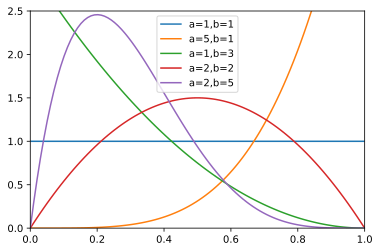

In [370]:
# test beta dis

plot_ab = [(1,1), (5,1), (1,3), (2,2), (2,5)]
plot_len = len(plot_ab)

plt.axis([0, 1, 0, 2.5])

for idx, (a, b) in enumerate(plot_ab):
    x = np.linspace(0,1,100)
    b_d = Beta_distribution(a, b)
    #plt.subplot(plot_len, 1, idx+1)
    plt.plot(x, [b_d(i) for i in x], label="a={},b={}".format(a,b))

plt.legend()
plt.show()

### Binomial Likelihood

$$ L = \prod_{i} (\begin{array}{clr} N_i \\ m_i \end{array})  p^{m_i}(1-p)^{N_i - m_i} $$

### Binomial MLE

use log and differential and get

$$ p = \frac{\sum_{i} m_i}{\sum_{i} N_i} $$


Prior(a,b) : (0,0)
Binomial MLE : 0.591,	 Prior(a,b) : (0,0),	 Posterior(a,b) : (13,9)
Binomial MLE : 0.714,	 Prior(a,b) : (13,9),	 Posterior(a,b) : (18,11)
Binomial MLE : 0.750,	 Prior(a,b) : (18,11),	 Posterior(a,b) : (27,14)
Binomial MLE : 0.902,	 Prior(a,b) : (27,14),	 Posterior(a,b) : (64,18)


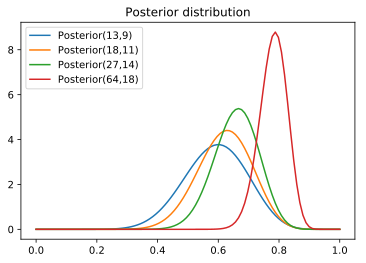

In [378]:
# beta distribution initial parameter

beta_a = 0
beta_b = 0

print("Prior(a,b) : ({},{})".format(beta_a, beta_b))
for idx, (N,m) in enumerate(online_datas):
    prior_a = beta_a
    prior_b = beta_b
    beta_a += m
    beta_b += N-m
    print("Binomial MLE : {:.3f},\t Prior(a,b) : ({},{}),\t Posterior(a,b) : ({},{})".format(m/N, prior_a, prior_b, beta_a, beta_b))
    
    #plt.subplot(len(online_datas)*2, 1, idx*2+1)
    x = np.linspace(0,1,100)
    b_d = Beta_distribution(beta_a, beta_b)
    plt.plot(x, [b_d(i) for i in x], label="Posterior({},{})".format(beta_a, beta_b))

plt.title("Posterior distribution")
plt.legend()
plt.show()